In [35]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns
%matplotlib inline

#Turn off scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import data
tn_budget = pd.read_csv('Data/Zipped_Data/tn.movie_budgets.csv.gz', compression = 'gzip')
bom_gross = pd.read_csv('Data/Zipped_Data/bom.movie_gross.csv.gz', compression = 'gzip')
imbd_basics = pd.read_csv('Data/Zipped_Data/imdb.title.basics.csv.gz', compression = 'gzip')
imbd_name = pd.read_csv('Data/Zipped_Data/imdb.name.basics.csv.gz', compression = 'gzip')
imbd_principals = pd.read_csv('Data/Zipped_Data/imdb.title.principals.csv.gz', compression = 'gzip')

In [3]:
#Remove punctuation from producton and worldwide. Switch variables from string to float.
tn_budget['production_budget'] = tn_budget['production_budget'].apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget['worldwide_gross'] = tn_budget['worldwide_gross'].apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget['production_budget'] = pd.to_numeric(tn_budget.production_budget, downcast = 'float', errors = 'coerce')
tn_budget['worldwide_gross'] = pd.to_numeric(tn_budget.worldwide_gross, downcast = 'float', errors = 'coerce')

#Create column for net profit (worldwide gross minus production budget).
tn_budget['net'] = list(tn_budget.apply(lambda x: x.worldwide_gross - x.production_budget, axis=1))

#Create column for ratio (net profit divided by production budget)
tn_budget['ratio'] = list(tn_budget.apply(lambda x: x.net / x.production_budget, axis=1))

# Rename column 'movie' to 'title'
tn_budget = tn_budget.rename(columns = {'movie': 'title'})

#remove whitespace, potential extra words, punctuation, and case from titles
years = ['\(2010\)', "\(2011\)", 
         "\(2012\)", "\(2013\)", "\(2014\)", 
         "\(2015\)", "\(2016\)", "\(2017\)", "\(2018\)"]
tn_budget.title = tn_budget.title.replace(years, value='', regex=True)
tn_budget.title = tn_budget.title.str.strip()
tn_budget.title = tn_budget.title.apply(lambda x: x.lower())
tn_budget.title = tn_budget.title.apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
tn_budget.title = tn_budget.title.replace(['the', 'and'], value='', regex=True)

#Remove month and year from date. Drop redundant columns
tn_budget['year'] = list(tn_budget['release_date'].str[-4:])
tn_budget = tn_budget.drop(columns = ['id', 'domestic_gross', 'release_date'])

In [4]:
#Remove 'studio', 'domestic_gross', 'foreign_gross' column. Set 'foreign_gross' to float and 'year' to string
bom_gross = bom_gross.drop(columns = ['domestic_gross', 'foreign_gross'])
bom_gross['year'] = bom_gross['year'].astype(str)

#Remove years and right whitespace from titles. Remove potentially extraneous words.
years = ['\(2010\)', "\(2011\)", 
         "\(2012\)", "\(2013\)", "\(2014\)", 
         "\(2015\)", "\(2016\)", "\(2017\)", "\(2018\)"]
bom_gross.title = bom_gross.title.replace(years, value='', regex=True)
bom_gross.title = bom_gross.title.str.strip()
bom_gross.title = bom_gross.title.apply(lambda x: x.lower())
bom_gross.title = bom_gross.title.apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
bom_gross.title = bom_gross.title.replace(['the', 'and'], value='', regex=True)

In [5]:
#Merge tn_budget and bom_gross
merged_df = pd.merge(tn_budget, bom_gross, on = ["title", "year"], how = "left")

#Replace null studio values
merged_df['studio'] = merged_df.studio.fillna('Unknown')

In [6]:
#Create 'year' string column from 'start_year'
imbd_basics['year'] = imbd_basics['start_year'].astype(str)

#Drop unused columns
imbd_basics = imbd_basics.drop(columns = ['original_title', 'start_year'])

#Rename column for easier merging
imbd_basics = imbd_basics.rename(columns = {'primary_title': 'title'})

#Remove years and right whitespace from titles. Remove potentially extraneous words.
years = ['\(2010\)', "\(2011\)", 
         "\(2012\)", "\(2013\)", "\(2014\)", 
         "\(2015\)", "\(2016\)", "\(2017\)", "\(2018\)"]
imbd_basics.title = imbd_basics.title.replace(years, value='', regex=True)
imbd_basics.title = imbd_basics.title.str.strip()
imbd_basics.title = imbd_basics.title.apply(lambda x: x.lower())
imbd_basics.title = imbd_basics.title.apply(lambda x: x.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')))
imbd_basics.title = imbd_basics.title.replace(['the', 'and'], value='', regex=True)

In [7]:
#Merge imbd_basics with merged datafile
merged_df2 = pd.merge(merged_df, imbd_basics, on = ["title", "year"], how = "left")

#Change year to integer, and remove all films made before 2010. Turn year back to string.
merged_df2['year'] = merged_df2['year'].astype(int)
merged_df2 = merged_df2.loc[merged_df2.year >= 2010]
merged_df2['year'] = merged_df2['year'].astype(str)

In [8]:
#Merge imbd_principals and imbd_name
imbd_name_prin = pd.merge(imbd_principals, imbd_name, on = ["nconst"], how = "left")

#Remove extraneous columns
imbd_name_prin = imbd_name_prin.drop(columns = ['ordering', 'nconst', 
                               'job', 'characters', 'birth_year', 'death_year', 
                               'primary_profession', 'known_for_titles'])

In [9]:
#Create list of directors from imbd_name_prin
directors = imbd_name_prin.loc[imbd_name_prin.category == 'director']

In [10]:
#Merge list of directors with merged document
merged_df3 = pd.merge(merged_df2, directors, on = ["tconst"], how = "left")

#Remove extra columns, rename primary_name to director
merged_df3 = merged_df3.drop(columns = ['category', 'runtime_minutes', 'genres'])
merged_df3 = merged_df3.rename(columns = {'primary_name': 'director'})

#Fill in null values for director
merged_df3['director'] = merged_df3.director.fillna('Not listed')

In [11]:
#Create list of producers from imbd_name_prin
producers = imbd_name_prin.loc[imbd_name_prin.category == 'producer']

#Rename column primary_name to producer
producers = producers.rename(columns = {'primary_name': 'producer'})

#Drop column 'category'
producers = producers.drop(columns = 'category')

In [12]:
#Merge list of producers with merged document
merged_df4 = pd.merge(merged_df3, producers, on = ["tconst"], how = "left")

#Fill null producer values
merged_df4['producer'] = merged_df4.producer.fillna('Not listed')

#Remove duplicate titles
merged_df_cleaned = merged_df4.loc[merged_df4.title.duplicated() == False]

#Drop extra column
merged_df_cleaned = merged_df_cleaned.drop(columns = 'tconst')

In [13]:
##### Create a list of 20 studios with the top ratio means
studio_ratio_mean = merged_df_cleaned.groupby(['studio']).ratio.mean().sort_values(ascending=False)[:20]

#Create a list of 20 directors with the top ratio means
director_ratio_mean = merged_df_cleaned.groupby(['director']).ratio.mean().sort_values(ascending=False)[:20]

#Create a list of 20 producers with the top ratio means
producer_ratio_mean = merged_df_cleaned.groupby(['producer']).ratio.mean().sort_values(ascending=False)[:20]

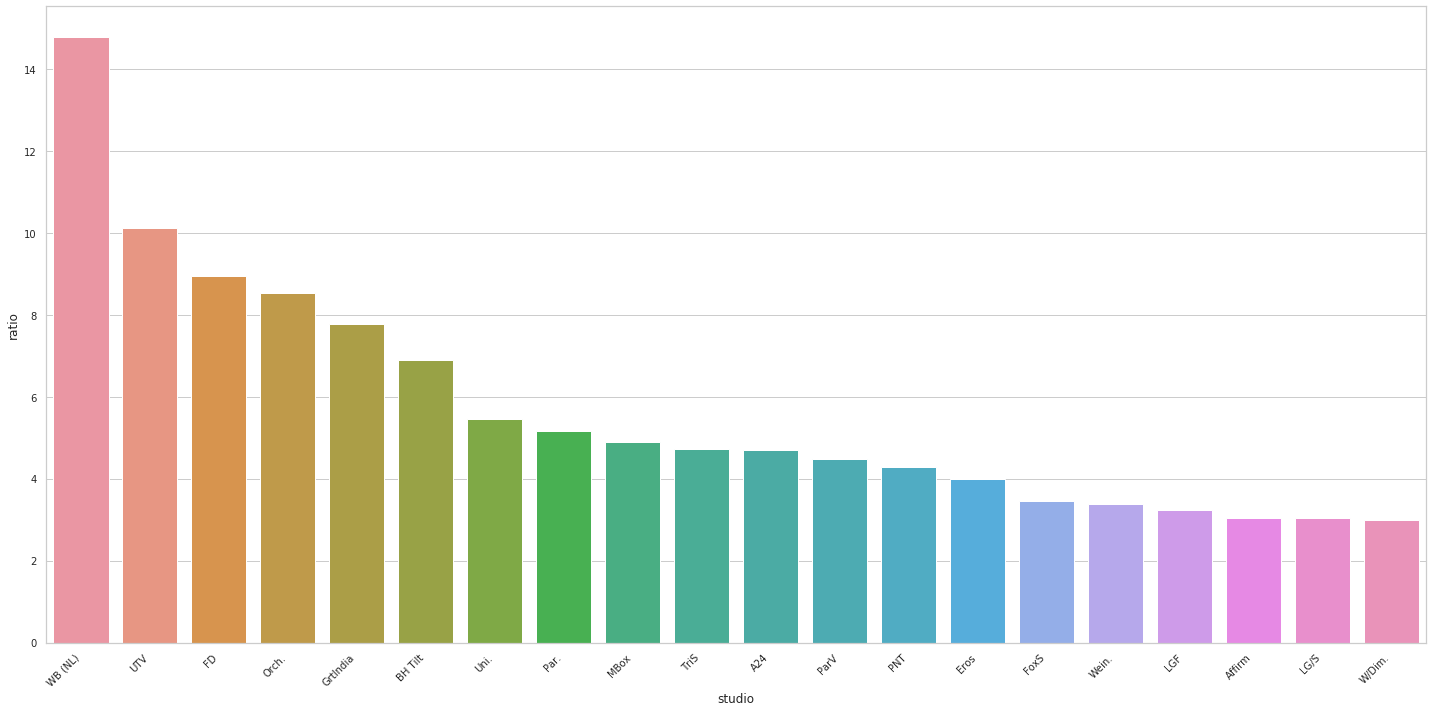

In [141]:
#Make a barplot - top 20 studios by ROI
top_20_studios_ROI = (merged_df_cleaned.groupby('studio')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='ratio', ascending=False))[:20].reset_index()
ax = sns.barplot(x = top_20_studios_ROI['studio'], y = top_20_studios_ROI['ratio'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

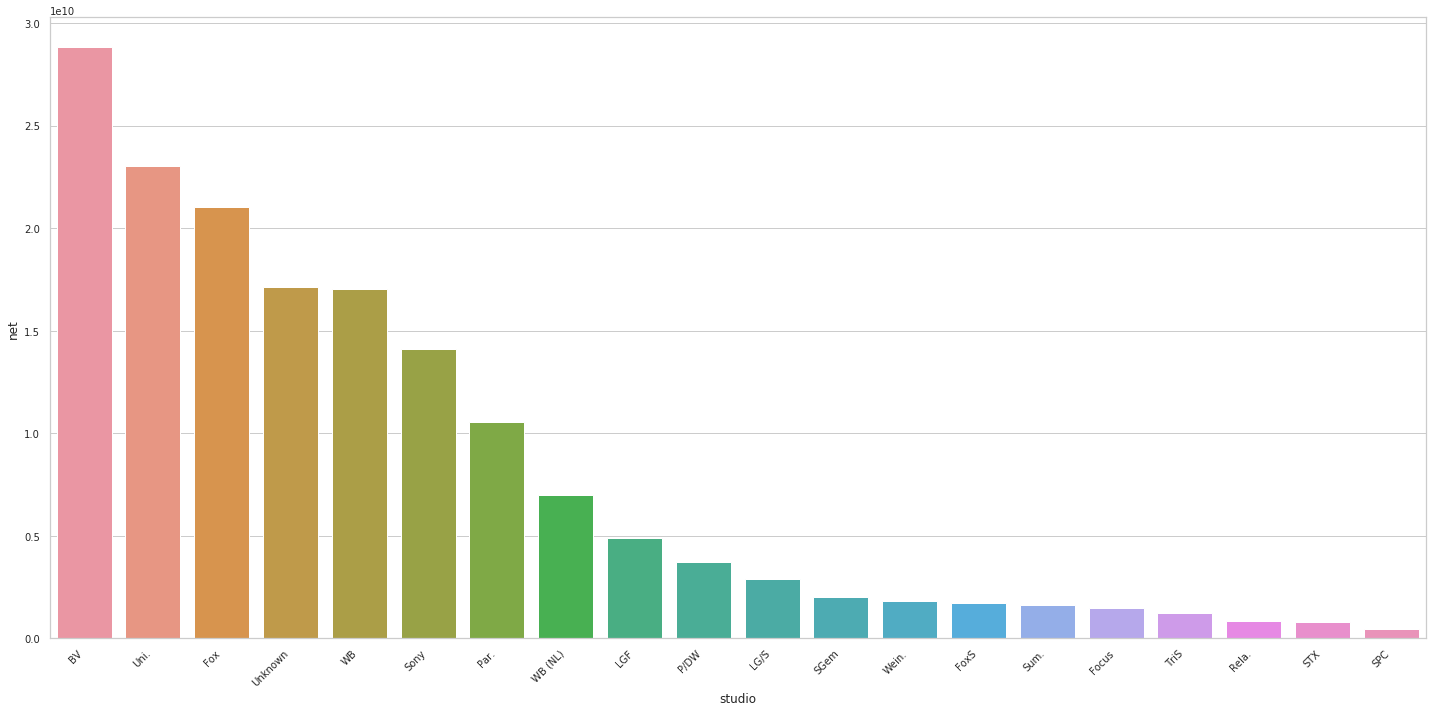

In [140]:
#Make a barplot - top 20 studios by net profit
top_20_studios_gross = (merged_df_cleaned.groupby('studio')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='net', ascending=False))[:20].reset_index()
ax = sns.barplot(x = top_20_studios_gross['studio'], y = top_20_studios_gross['net'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

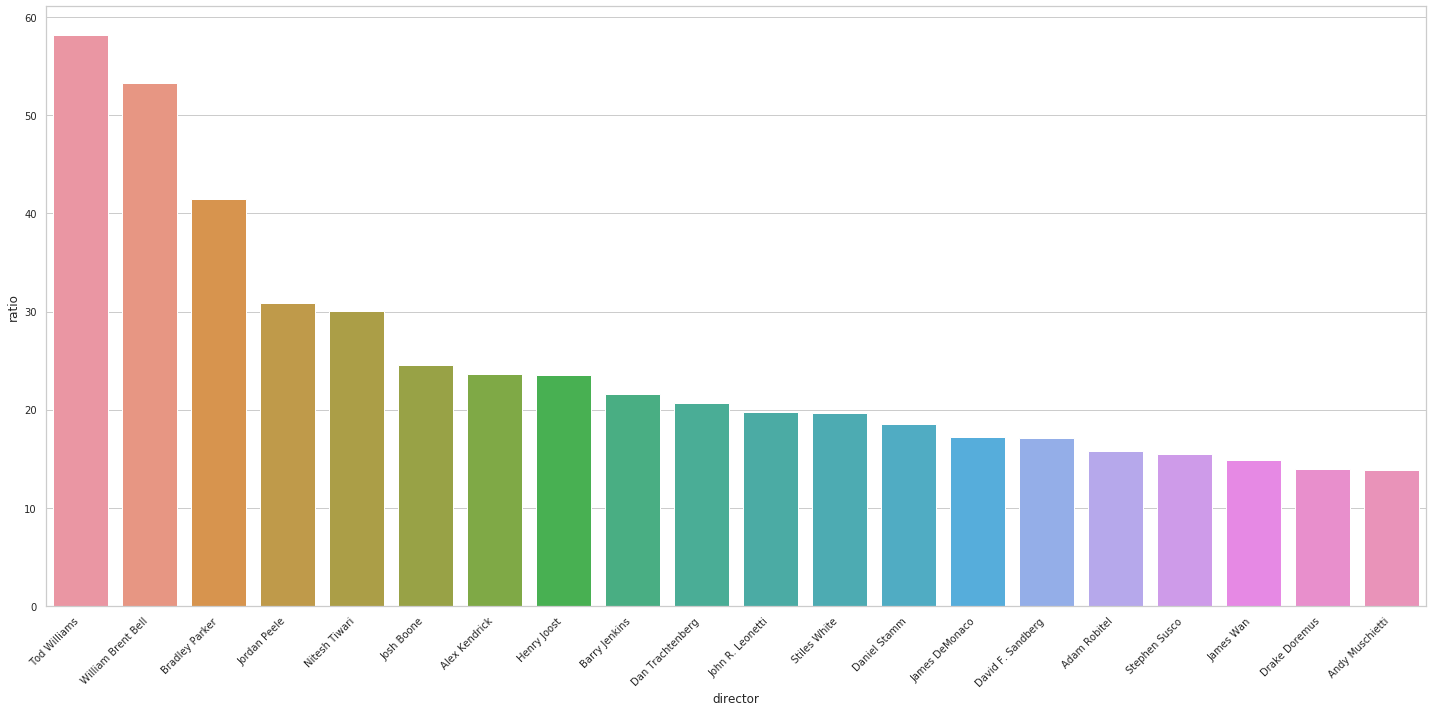

In [146]:
#Make a barplot - top 20 directors by ROI
top_20_directors_ROI = (merged_df_cleaned.groupby('director')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='ratio', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_directors_ROI['director'], y = top_20_directors_ROI['ratio'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()
#N.B. - Dropped Travis Cluff due to assumed outlier status.

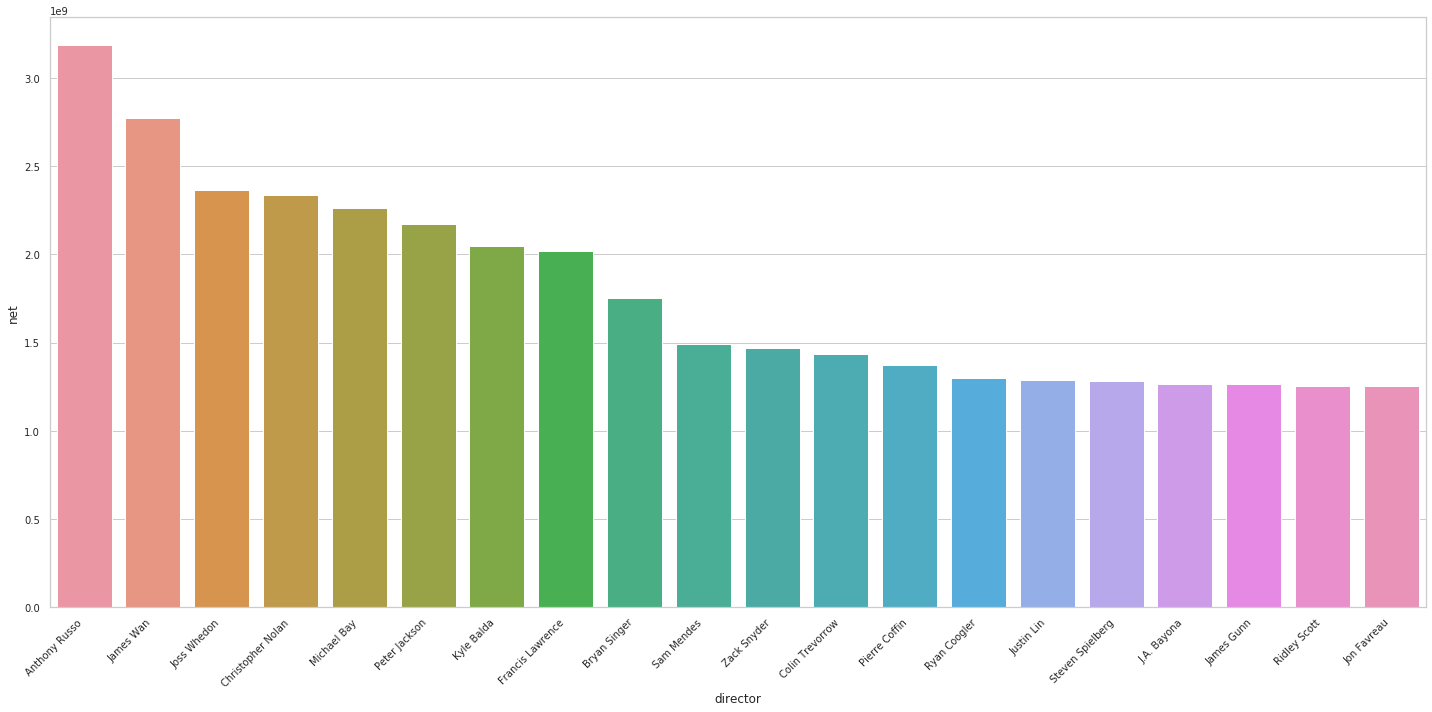

In [145]:
#Make a barplot - top 20 directors by net profit
top_20_directors_gross = (merged_df_cleaned.groupby('director')['net', 'ratio'].agg({'net': 'sum', 'ratio': 'mean'}).sort_values(by='net', ascending=False))[1:21].reset_index()
ax = sns.barplot(x = top_20_directors_gross['director'], y = top_20_directors_gross['net'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2190 entries, 0 to 4176
Data columns (total 9 columns):
title                2190 non-null object
production_budget    2190 non-null float32
worldwide_gross      2190 non-null float32
net                  2190 non-null float64
ratio                2190 non-null float64
year                 2190 non-null object
studio               2190 non-null object
director             2190 non-null object
producer             2190 non-null object
dtypes: float32(2), float64(2), object(5)
memory usage: 234.0+ KB


In [56]:
merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2190 entries, 0 to 4176
Data columns (total 9 columns):
title                2190 non-null object
production_budget    2190 non-null float32
worldwide_gross      2190 non-null float32
net                  2190 non-null float64
ratio                2190 non-null float64
year                 2190 non-null object
studio               2190 non-null object
director             2190 non-null object
producer             2190 non-null object
dtypes: float32(2), float64(2), object(5)
memory usage: 234.0+ KB


In [86]:
director_ratio_mean

director
Travis Cluff         415.56
Tod Williams          58.17
William Brent Bell    53.29
Bradley Parker        41.41
Jordan Peele          30.89
Nitesh Tiwari         30.02
Josh Boone            24.60
Alex Kendrick         23.66
Henry Joost           23.50
Barry Jenkins         21.58
Dan Trachtenberg      20.66
John R. Leonetti      19.74
Stiles White          19.66
Daniel Stamm          18.50
James DeMonaco        17.22
David F. Sandberg     17.13
Adam Robitel          15.79
Stephen Susco         15.43
James Wan             14.86
Drake Doremus         13.91
Name: ratio, dtype: float64

In [85]:
producer_ratio_mean

producer
Dean Schnider            415.56
Morris Paulson           100.76
Brian Witten              41.41
Lawrence Grey             28.76
Adam Donaghey             26.70
Malek Akkad               24.49
Mike Medavoy              24.48
Steven Schneider          21.65
Lindsey Weber             20.66
Seth Grahame-Smith        18.93
Brandt Andersen           18.59
Sébastien K. Lemercier    17.22
Jamie Patricof            15.57
Jim Beach                 15.27
Dede Gardner              15.23
Jason Blum                14.52
Teddy Schwarzman          14.18
Jonathan Schwartz         13.91
Siddharth Roy Kapur       13.78
Peter Safran              13.40
Name: ratio, dtype: float64